In [1]:
# general imports
import random
import numpy as np
import math
import os
import time
import sys

# external files
import level_gen_sql
import aesthetic_bot
import TPKLDiv
import utils


%matplotlib inline

In [2]:
# global variables
TILENAMES = ["zelda","pokemon","pacman","amongus","dungeon"]

print("***********************    AESTHETIC BOT TWITTER: PART 0    ************************")
print("BACKEND LEVEL GENERATOR".center(84))

conf_file = "aesth_config.yaml"
conf = utils.readConfig(conf_file)

# SET CUSTOM DIRECTORY HERE
conf['AESTHETIC_BOT_DIR'] = 'cnn_models/9.2b'


if conf['SHOW_CONFIG']:
    print(f"---------- CONFIGURATION FILE: {conf_file} -----------")
    for k,v in conf.items():
        k2 = k+":"
        print(f"* {k2.ljust(40)}{v}")

    print("--------------------------------------------------------------------")

    
BINARY = (conf['AESTHETIC_BOT_DIR'][-1] == 'b')
print(f'**  USING [ {("BINARY" if BINARY else "WHOLE")} ] FORMAT FOR EVALUATION **')

***********************    AESTHETIC BOT TWITTER: PART 0    ************************
                              BACKEND LEVEL GENERATOR                               
---------- CONFIGURATION FILE: aesth_config.yaml -----------
* SHOW_CONFIG:                            True
* DEBUG_MODE:                             False
* REPEAT_STEP_0:                          False
* REPEAT_STEP_1:                          False
* STEP_0_FREQ:                            60
* STEP_1_FREQ:                            60
* TP_MAP_SET:                             winner
* AESTHETIC_BOT_DIR:                      cnn_models/9.2b
* EVO_ITERATIONS:                         250
* EVO_TRIALS:                             8
* EVO_POPSIZE:                            32
* EVO_MUTATION_RATE:                      0.03
* EVO_MU:                                 0.9
* EVO_DIM_RATE:                           0.01
* EVO_FINAL_SEL:                          twit_entropy
* EVO_RANK_TP_SEL:                        True
* EV

** WARNING: Level ID [ 68 ] from [ gen ] dataset not found! **


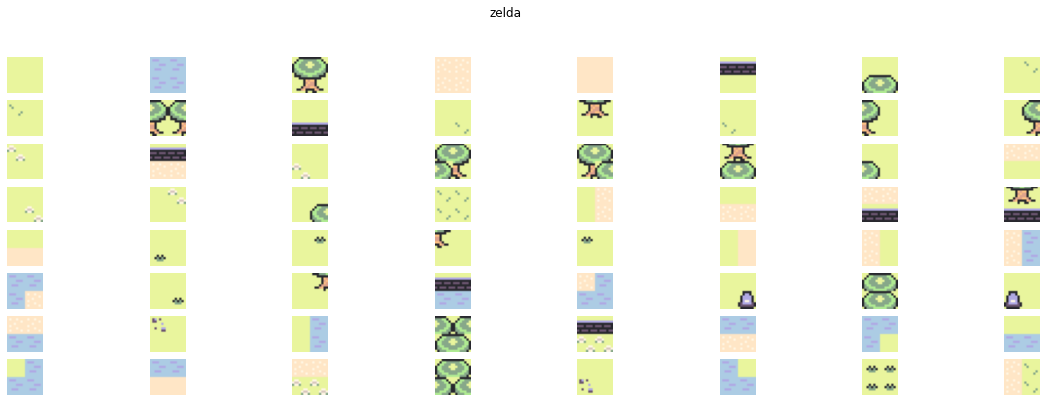

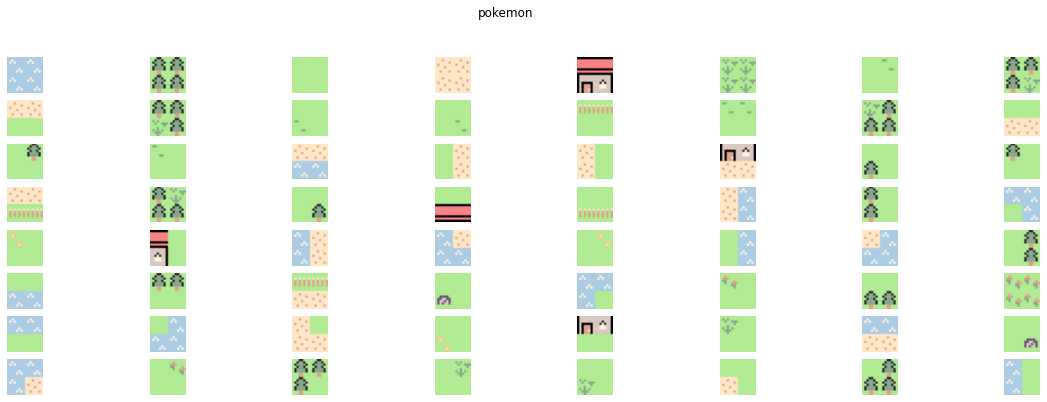

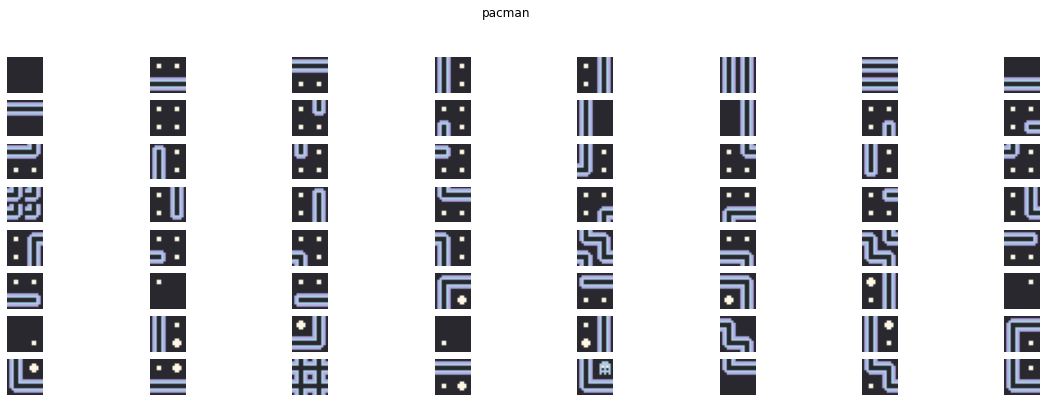

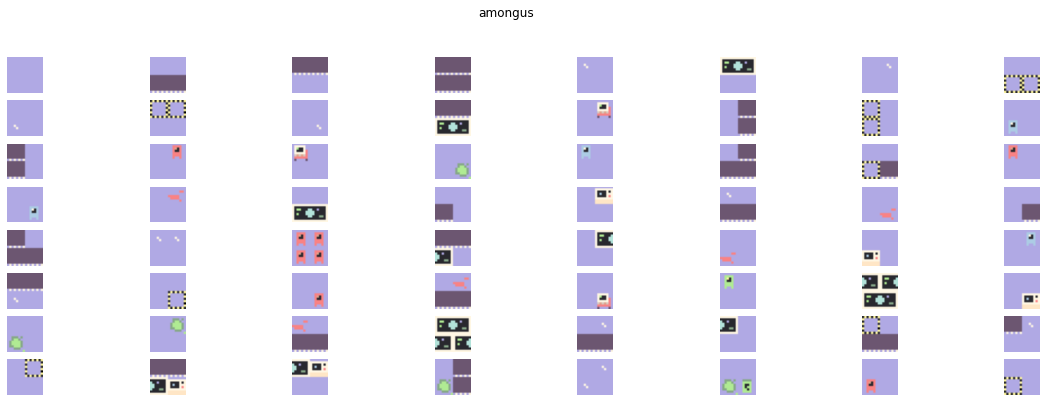

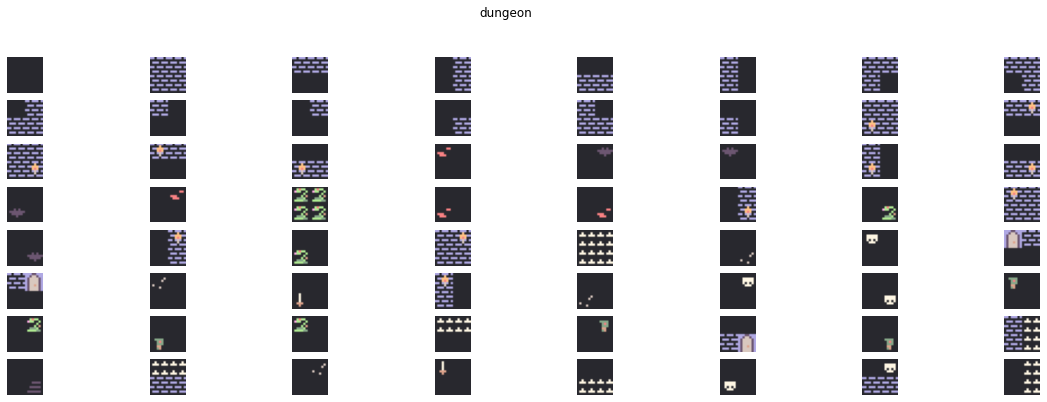

In [3]:
TILESETS = {}
AESTH_BOT_CNN = {}
TILE_PATTERNS = {}
TILE_PATT_DICT = {}

# get the tilesets
for t in TILENAMES:
    TILESETS[t] = level_gen_sql.Tileset(t)

# get the fitness CNN bots
for t in TILENAMES:
    botCNN = aesthetic_bot.FitnessCNN(TILESETS[t],("binary" if BINARY else 'whole'))
    botCNN.importModel(conf['AESTHETIC_BOT_DIR'],t)
    AESTH_BOT_CNN[t] = botCNN
    
# (import winning levels)
winnerLevels = []
if conf['TP_MAP_SET'] == "winner":
    winnerLevels = utils.getWinningLevelSet()

# get the tile patterns (array and dict)
for t in TILENAMES:
    if conf['TP_MAP_SET'] == "user":
        all_train_levels = utils.getAscUserLevels(t)
    else:
        all_train_levels = winnerLevels[t]
    TILE_PATT_DICT[t] = TPKLDiv.getTPProb(all_train_levels)
    if conf['EVO_RANK_TP_SEL']:
        TILE_PATTERNS[t] = TPKLDiv.getPatternList2dSorted(all_train_levels)
    else:
        TILE_PATTERNS[t] = TPKLDiv.getPatternList2d(all_train_levels)
        
    # show the tilepatterns
    utils.showMultiMaps(TILE_PATTERNS[t][:64],t,t)

> GENERATING [ zelda ] MAPS...


iter: 4 - fit: 0.27 - N: 9.00:   2%|▏         | 4/250 [00:00<00:17, 13.91it/s]/Users/milk/Desktop/GIL_Lab/aesthetic_bot/AestheticBot/py_code/aesthetic_bot.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.population = np.array(next_gen_pop)
iter: 250 - fit: 0.85 - N: 7.00: 100%|██████████| 250/250 [00:13<00:00, 18.57it/s]


> [DEBUG] VIEWING LEVEL
> GENERATING [ pokemon ] MAPS...


iter: 250 - fit: 0.82 - N: 6.94: 100%|██████████| 250/250 [00:13<00:00, 18.48it/s]


> [DEBUG] VIEWING LEVEL
> GENERATING [ pacman ] MAPS...


iter: 250 - fit: 0.74 - N: 8.00: 100%|██████████| 250/250 [00:15<00:00, 16.01it/s]
/Users/milk/Desktop/GIL_Lab/aesthetic_bot/AestheticBot/py_code/utils.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,7))
iter: 250 - fit: 0.71 - N: 9.00: 100%|██████████| 250/250 [00:18<00:00, 13.18it/s]


> [DEBUG] VIEWING LEVEL
> GENERATING [ amongus ] MAPS...


iter: 250 - fit: 0.69 - N: 8.00: 100%|██████████| 250/250 [00:15<00:00, 16.48it/s]


> [DEBUG] VIEWING LEVEL
> GENERATING [ dungeon ] MAPS...


iter: 250 - fit: 0.85 - N: 8.06: 100%|██████████| 250/250 [00:15<00:00, 16.12it/s]


> [DEBUG] VIEWING LEVEL


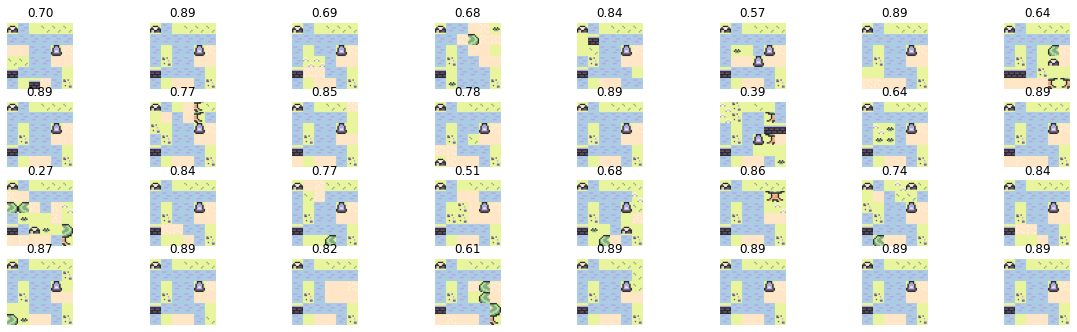

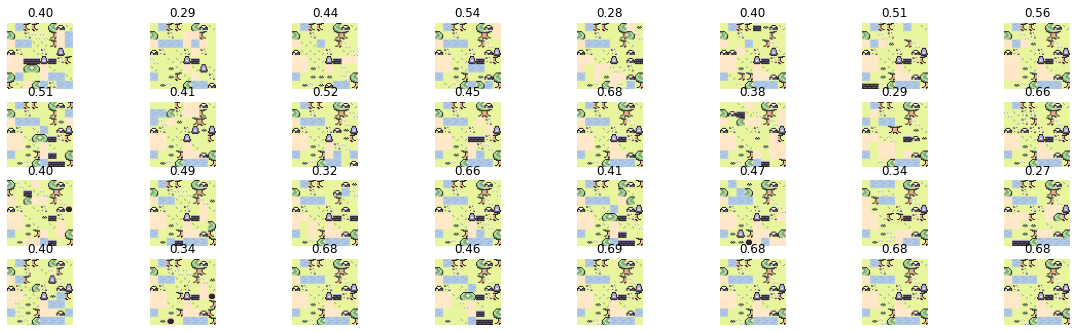

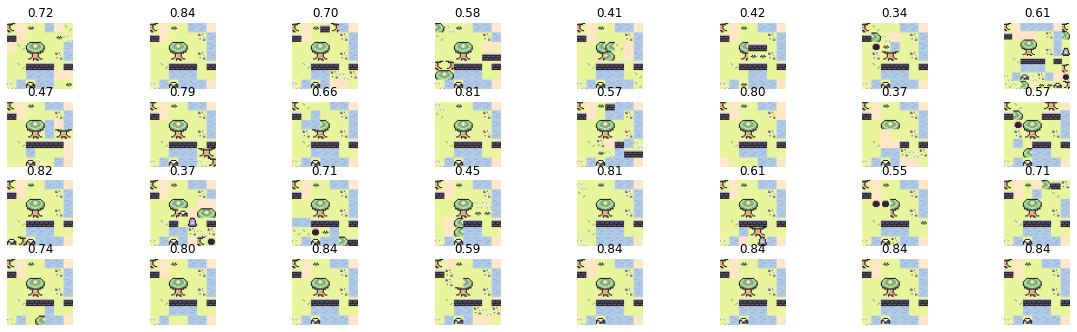

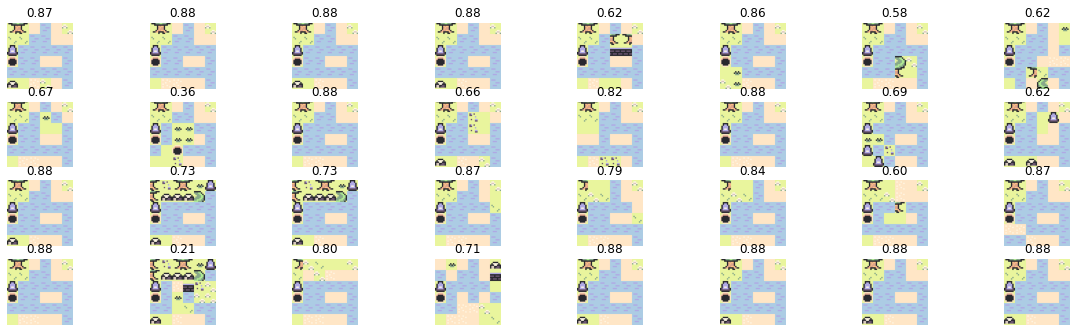

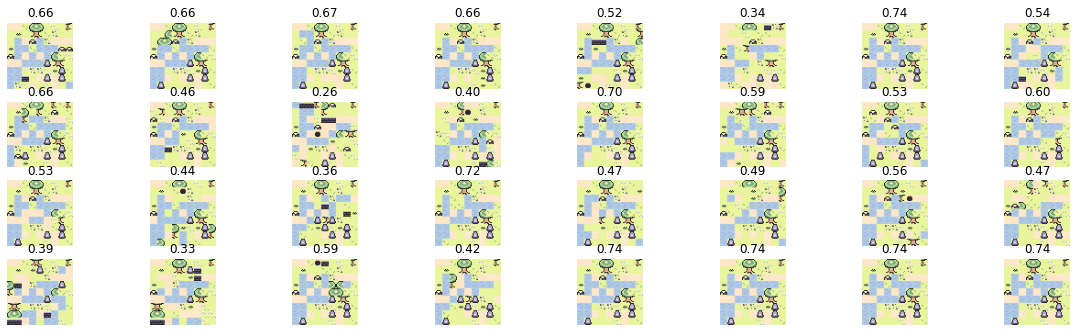

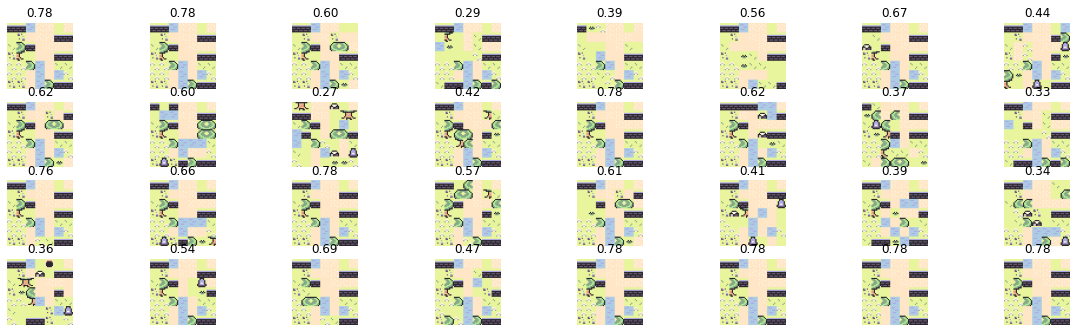

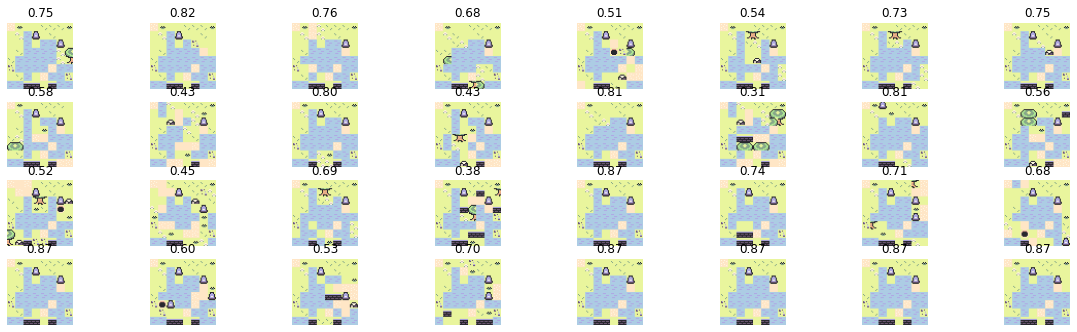

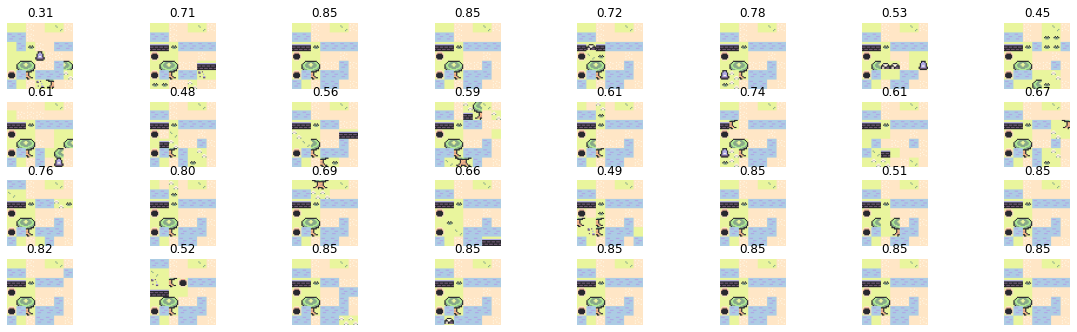

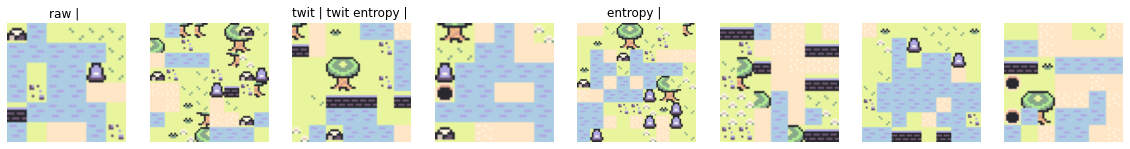

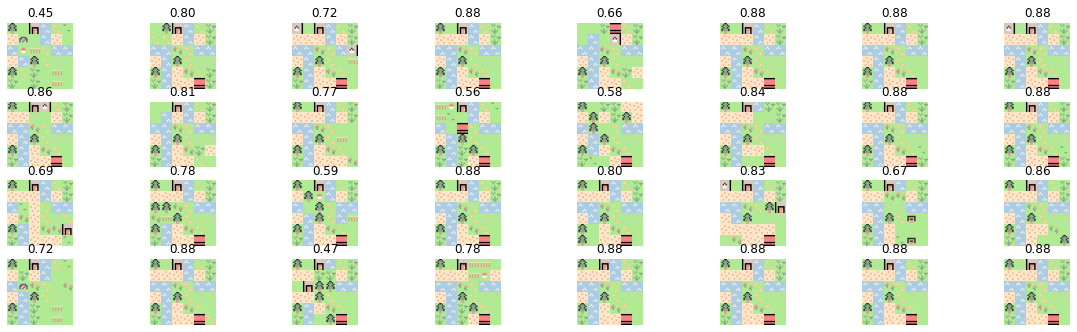

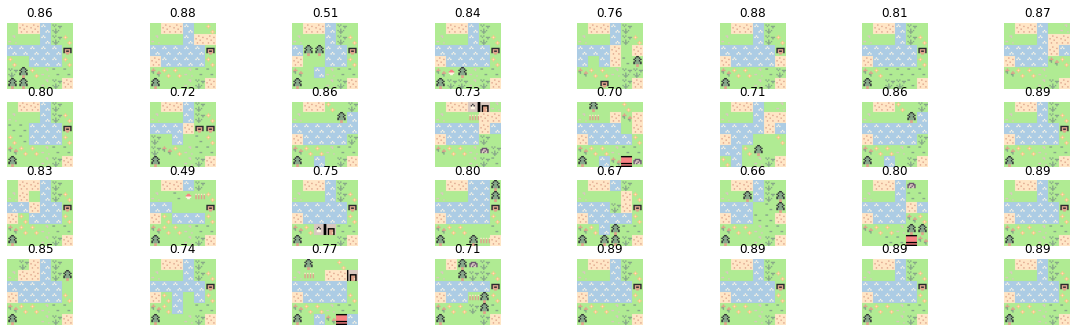

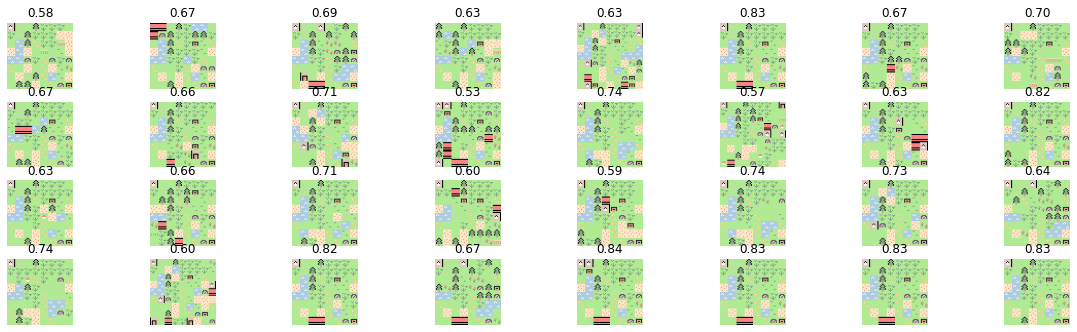

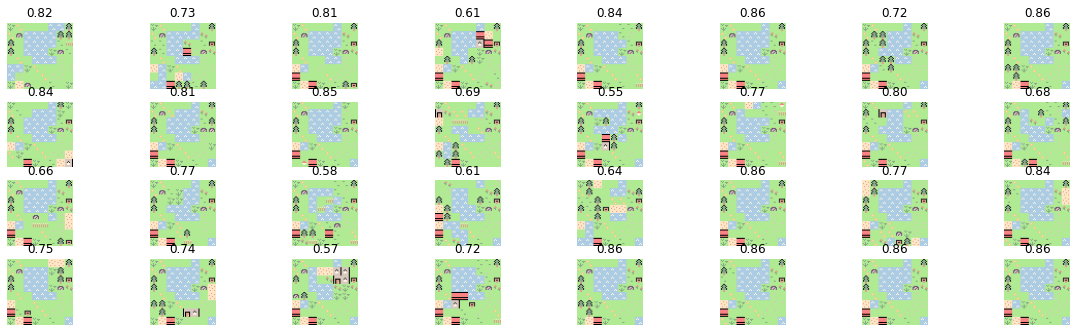

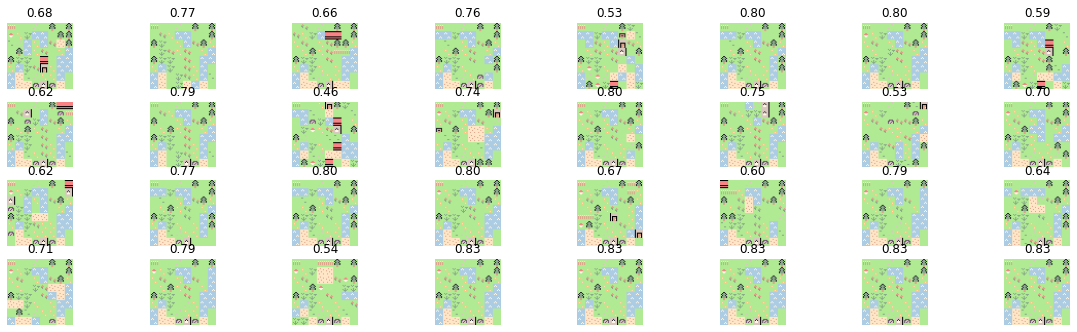

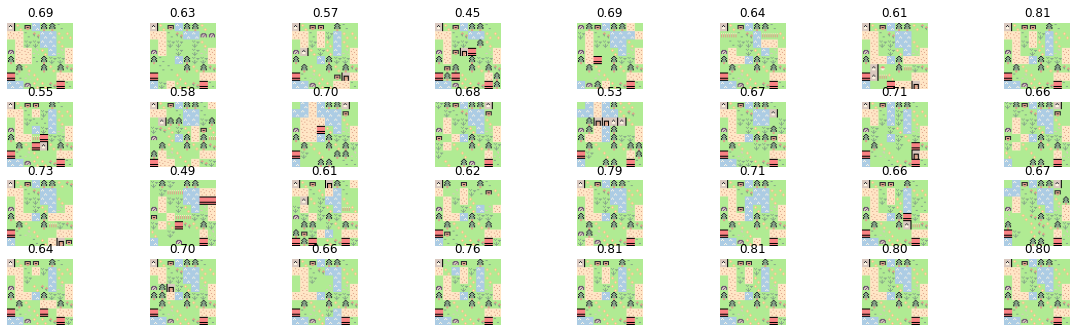

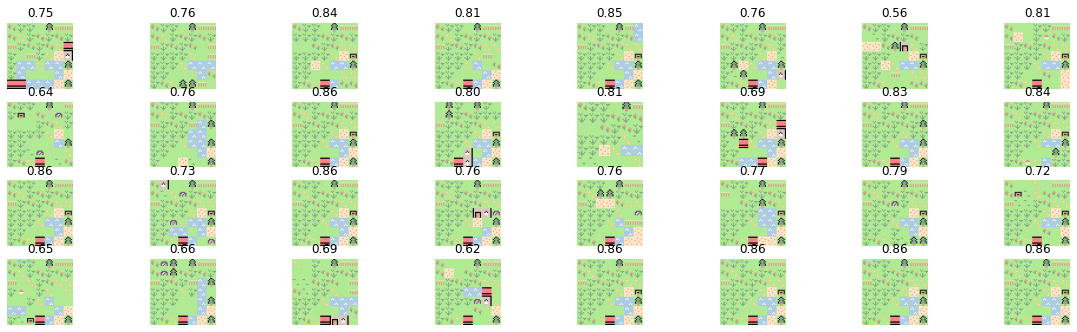

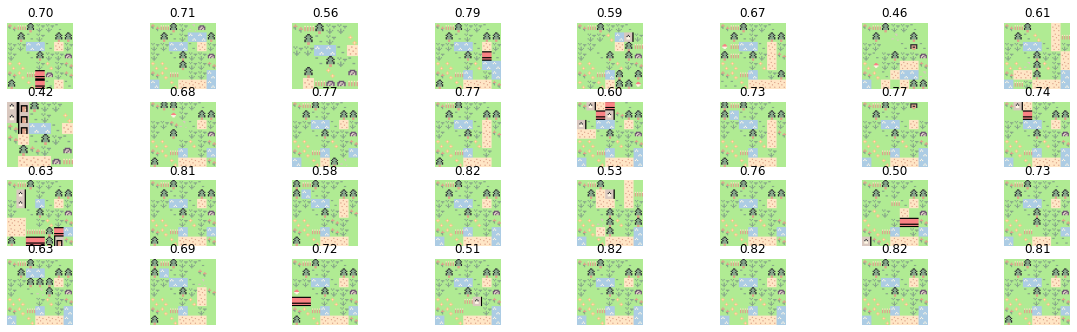

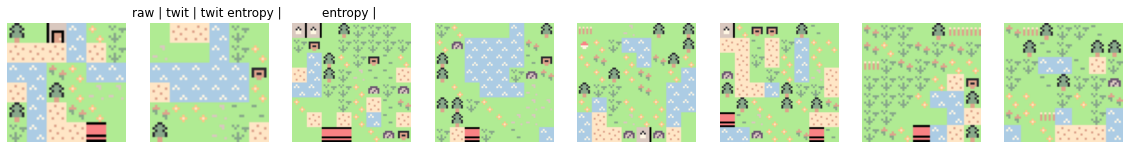

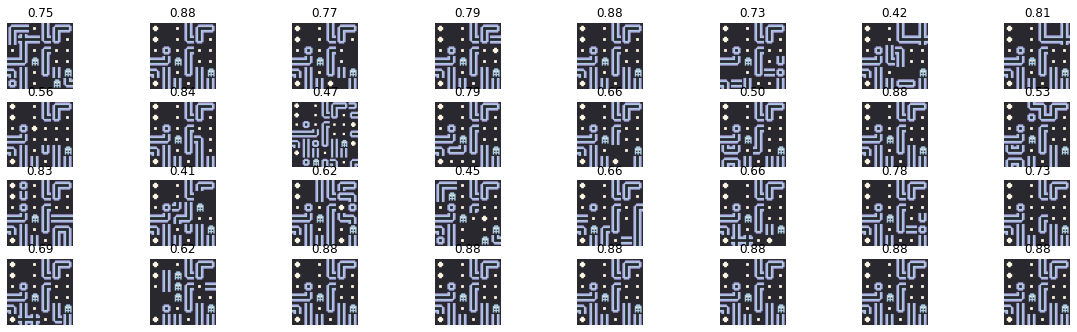

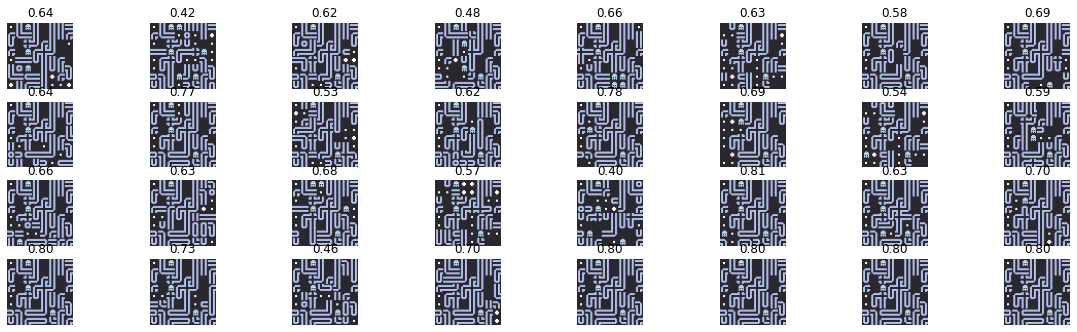

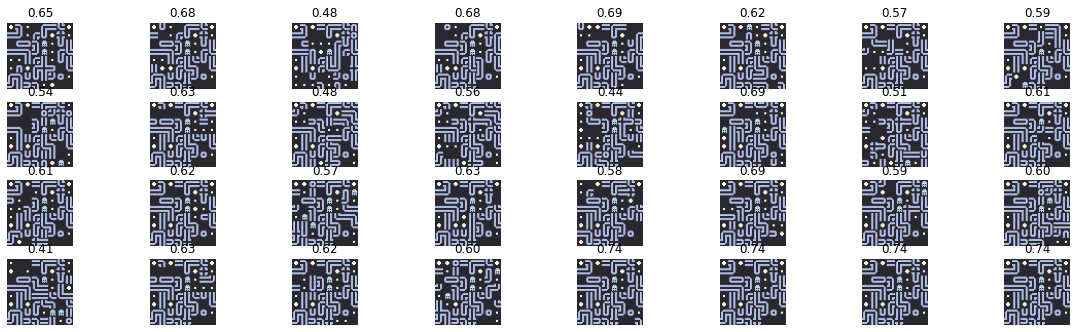

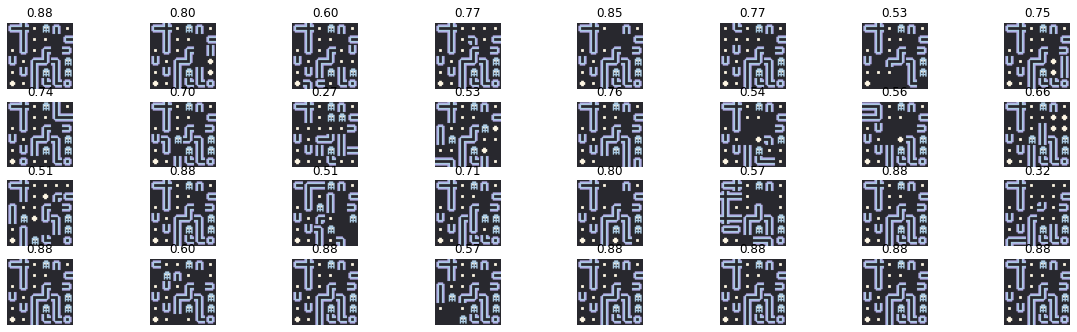

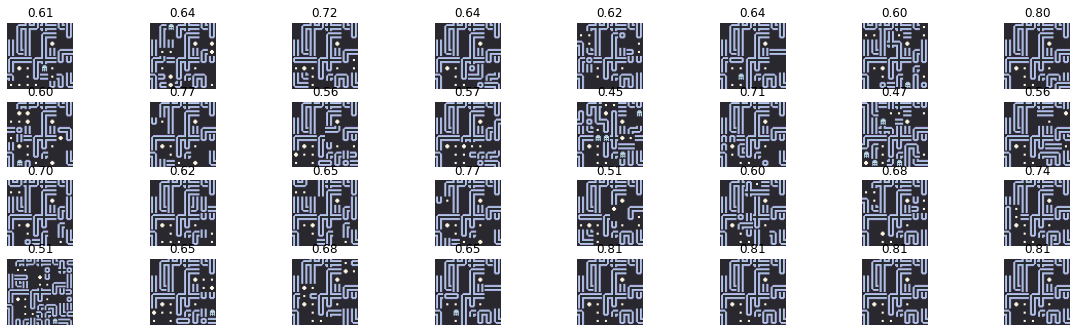

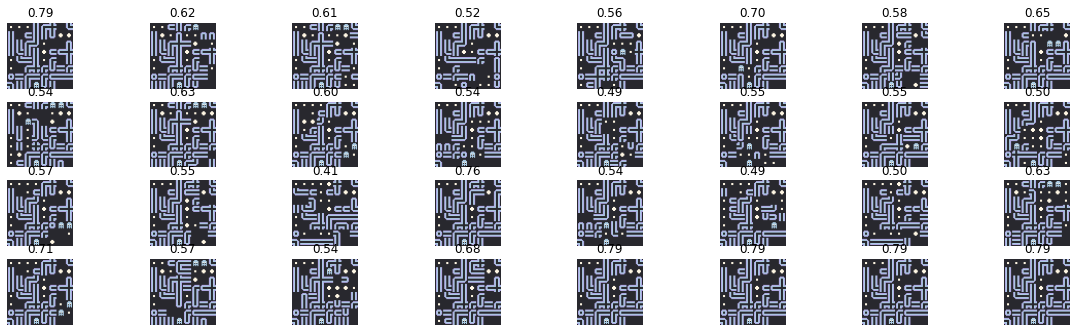

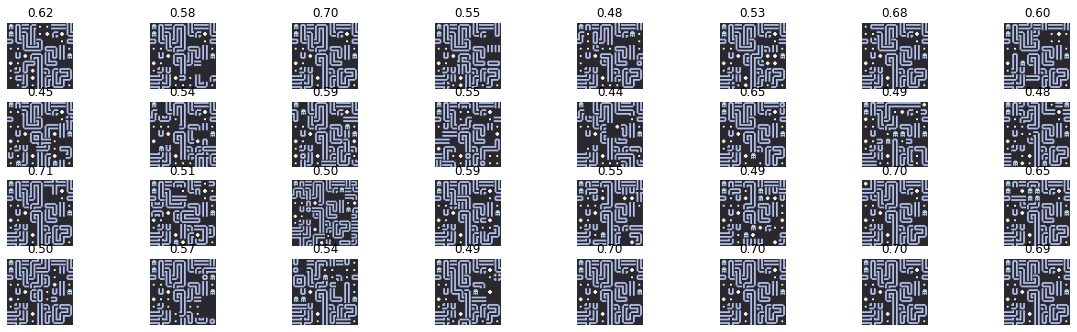

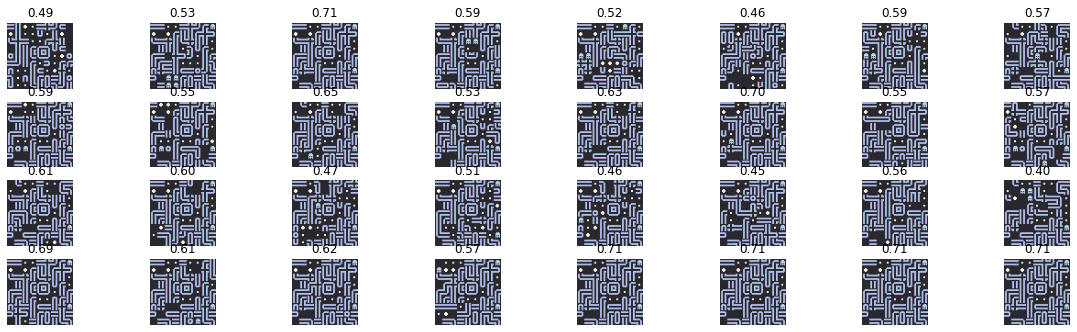

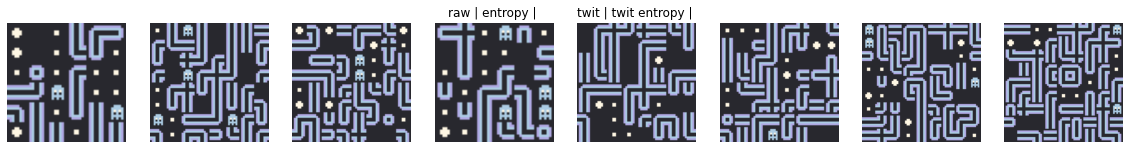

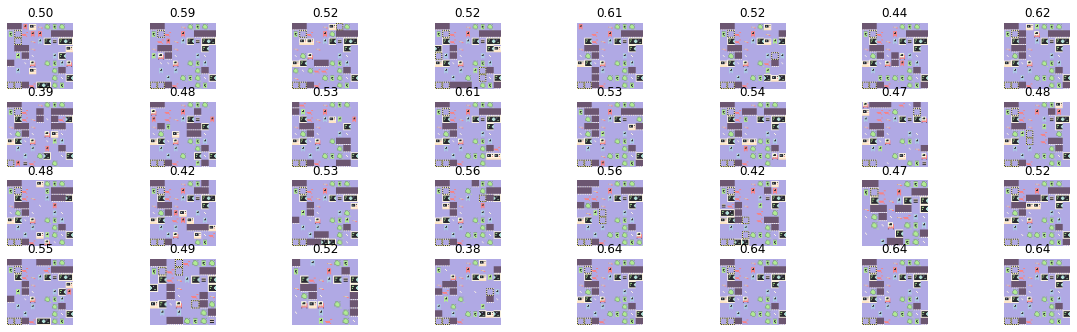

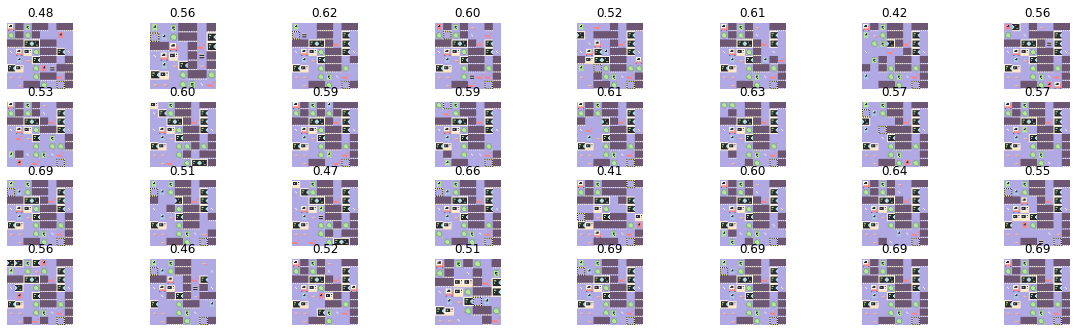

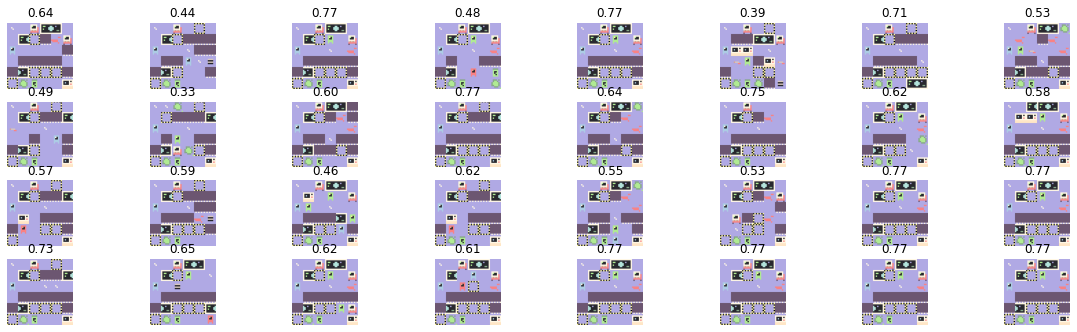

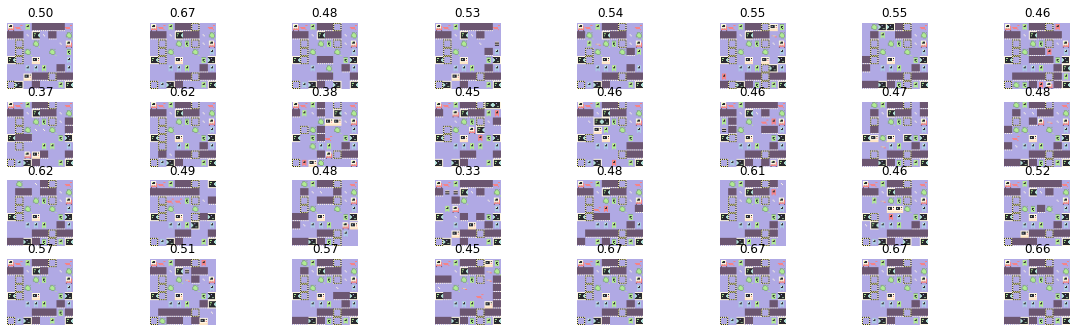

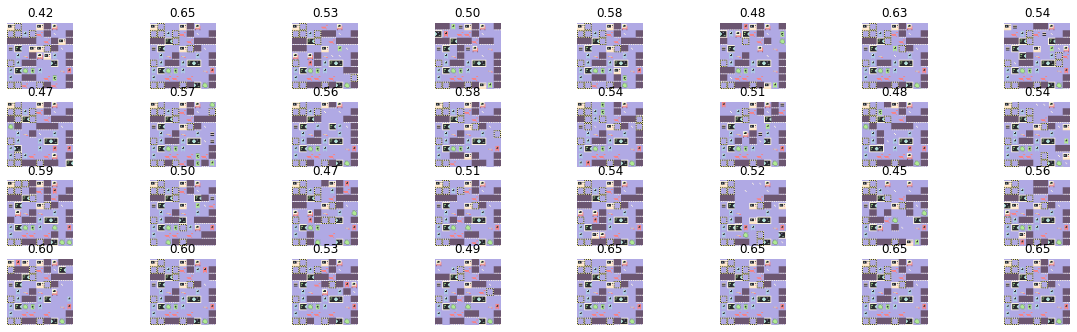

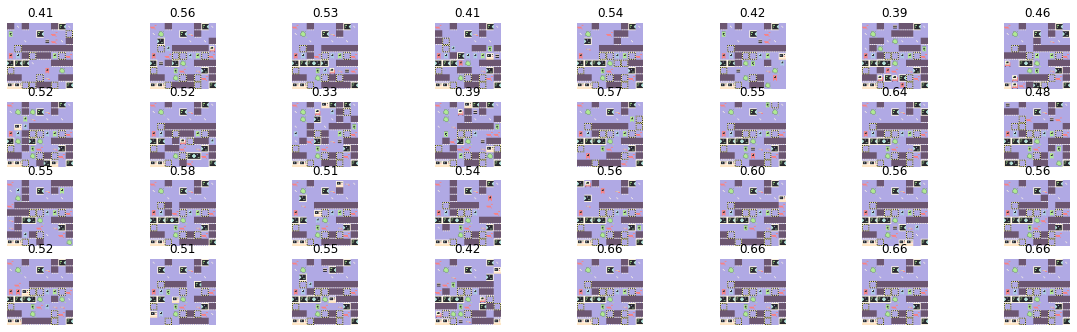

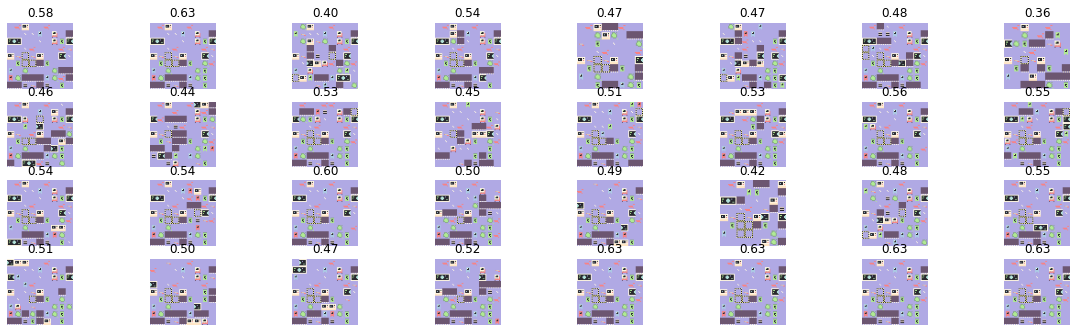

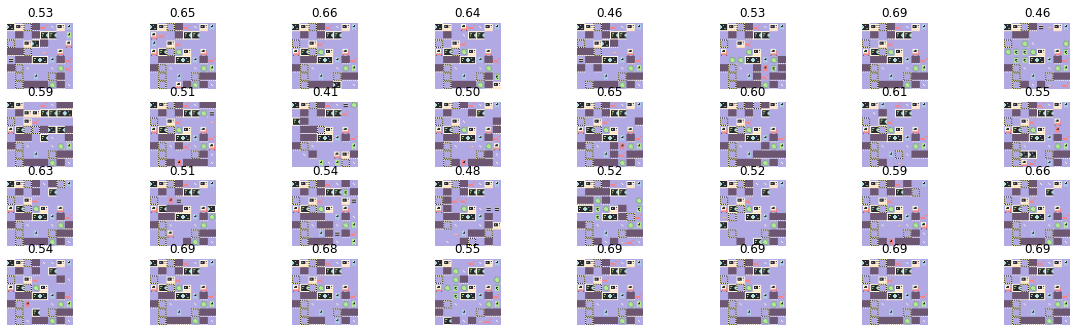

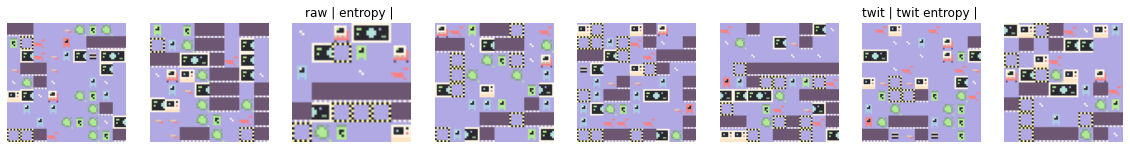

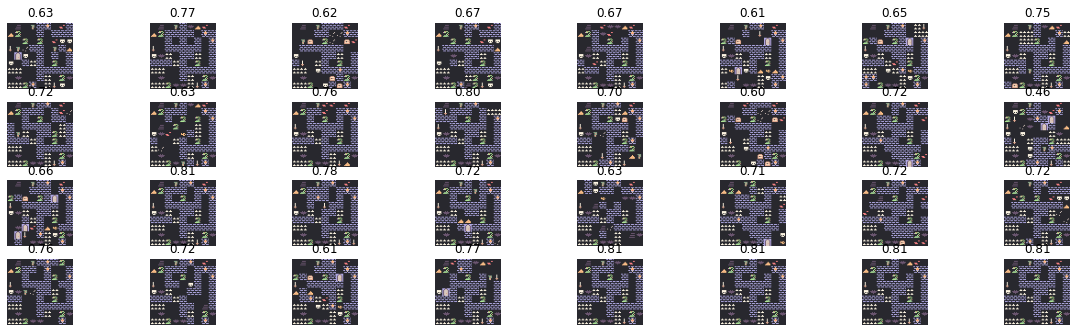

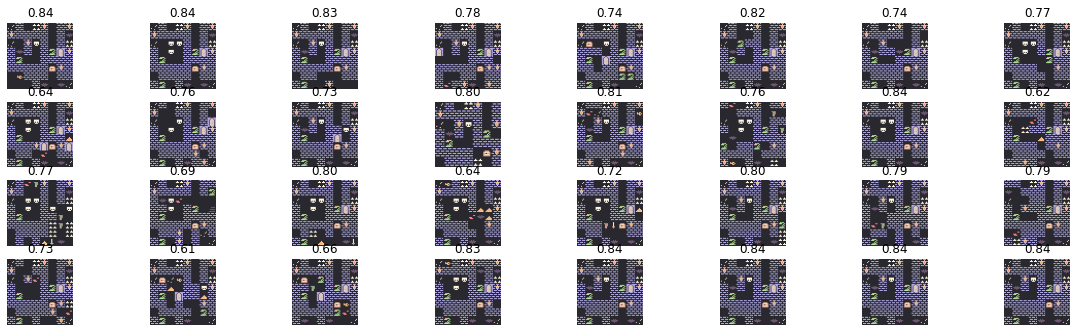

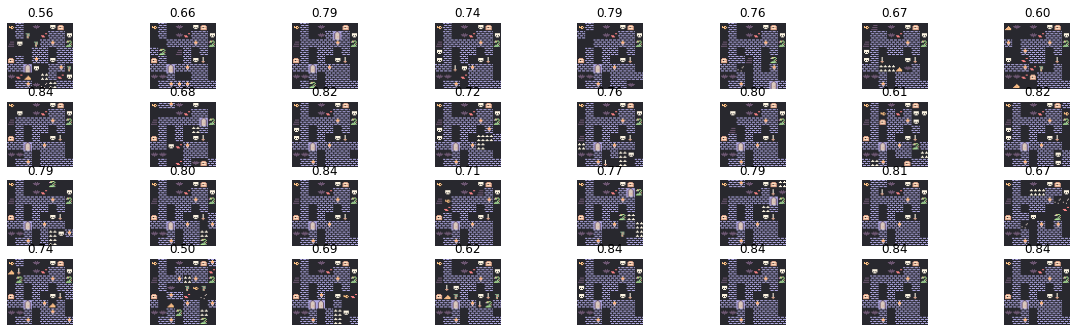

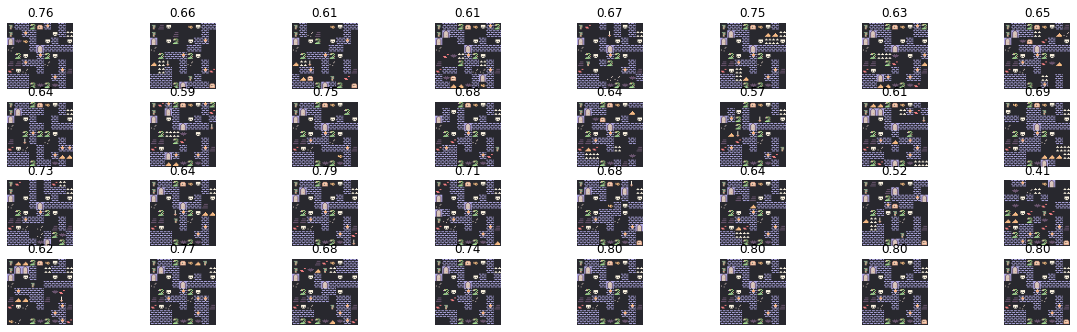

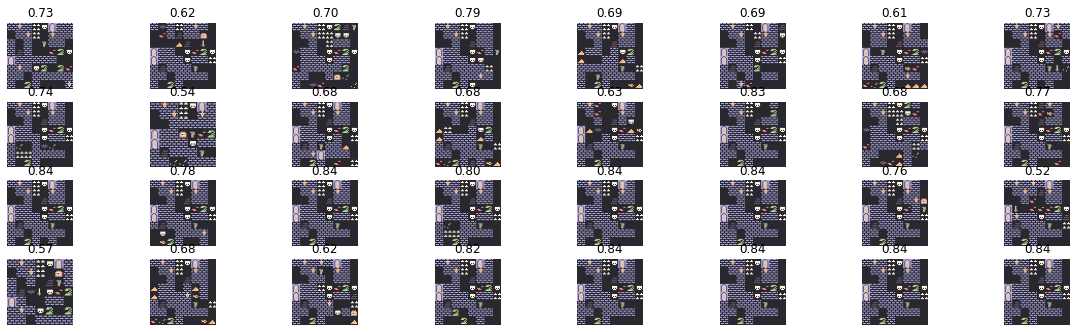

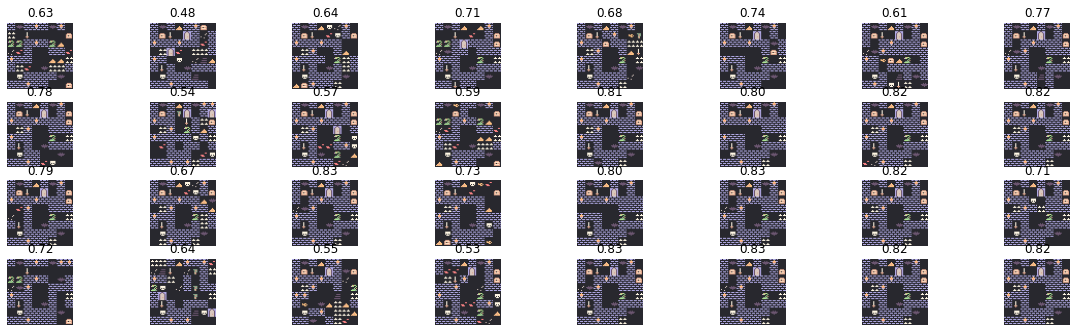

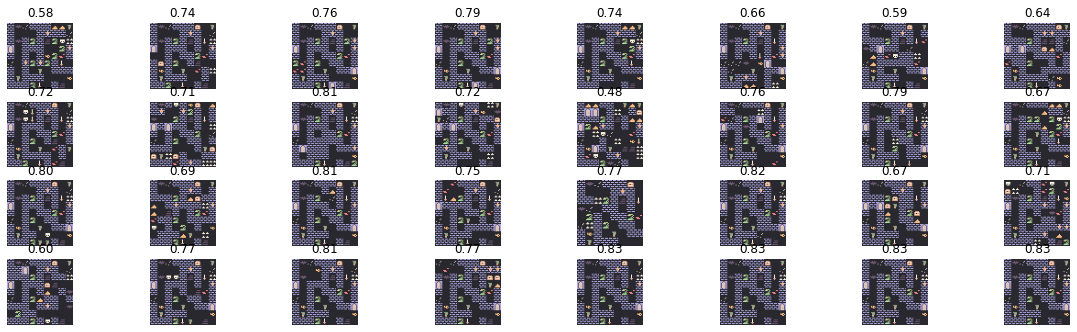

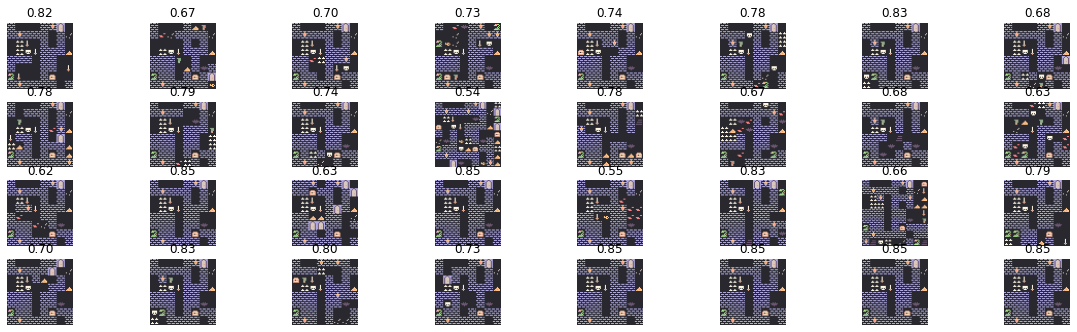

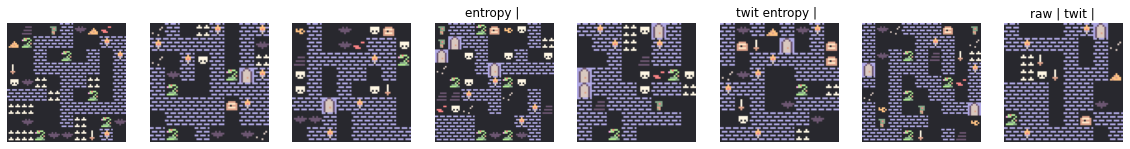

In [4]:
# 1a. make a new level for each tileset by evolving it and evaluating it
for curTilename in TILENAMES:
    print(f"> GENERATING [ {curTilename} ] MAPS...")
    curTileset = TILESETS[curTilename]
    tilesetPatterns = TILE_PATTERNS[curTilename]

    # 1b. Get the best generated map and export it
    bestGenLevels = []
    bestFit = []
    for trialNo in range(conf['EVO_TRIALS']):
        AesthBot = AESTH_BOT_CNN[curTilename]
        EvoBot = aesthetic_bot.StraightBotTP(curTileset,conf['EVO_POPSIZE'],conf['EVO_MUTATION_RATE'],tilesetPatterns,mu=conf['EVO_MU'],exprate=conf['EVO_DIM_RATE'],rank_tp_sel=conf['EVO_RANK_TP_SEL'])
        EvoBot.user_fun = AesthBot.eval_map_population

        #evolve for X iterations
        EvoBot.train(conf['EVO_ITERATIONS'])

        #continue training if fitness still negative and able to improve
        iter_ct = 0
        while (EvoBot.high_pop_fit() <= (0.5 if BINARY else 0)) and iter_ct < 10:
            EvoBot.train(100,False)
            iter_ct+=1

        #save the best map from the population
        best_map = EvoBot.best_map()
        bestGenLevels.append(best_map)
        bestFit.append(EvoBot.high_pop_fit())

        # SHOW THE POPULATION
        utils.showMultiMaps(EvoBot.population,curTilename,'',[f"{x:.2f}" for x in EvoBot.user_fun(EvoBot.population)])
        

    # final selection
    #"evo_fitness":	
    best_index1 = np.argmax(bestFit)         # highest fitness
    #"entropy":
    best_index2 = np.argmax([bestFit[i]*utils.entropy(bestGenLevels[i]) for i in range(len(bestGenLevels))])  #entropy
    #"pseudo_twitter":
    best_index3 = np.argmax([utils.twitterFit(m,TILE_PATT_DICT[curTilename],SAMP_WEIGHT=0.7,TWIT_OFFSET=7) for m in bestGenLevels])      #evaluate by twitter surrogate
    #'twit_entropy':
    best_index4 = np.argmax([utils.twitterFit(m,TILE_PATT_DICT[curTilename],SAMP_WEIGHT=0.7,TWIT_OFFSET=7)*utils.entropy(m) for m in bestGenLevels])

    # 1c. add the generated level to the database
    print(f"> [DEBUG] VIEWING LEVEL")
    txt = []
    for x in range(len(bestGenLevels)):
        t = ""
        t += "raw | " if best_index1 == x else ""
        t += "entropy | " if best_index2 == x else ""
        t += "twit | " if best_index3 == x else ""
        t += "twit entropy | " if best_index4 == x else ""
        txt.append(t)
    utils.showMultiMaps(bestGenLevels,curTilename,'',txt)


In [5]:
AESTH_BOT_CNN["pokemon"].reg_model.summary()

Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_402 (Conv2D)         (None, 2, 2, 64)          4160      
                                                                 
 batch_normalization_402 (Ba  (None, 2, 2, 64)         256       
 tchNormalization)                                               
                                                                 
 re_lu_402 (ReLU)            (None, 2, 2, 64)          0         
                                                                 
 max_pooling2d_268 (MaxPooli  (None, 2, 2, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_403 (Conv2D)         (None, 1, 1, 32)          8224      
                                                                 
 batch_normalization_403 (Ba  (None, 1, 1, 32)      